# BIM - PyTorch Implementation

This is a PyTorch implementation of the paper [Adversarial Examples in the Physical World](https://arxiv.org/abs/1607.02533) by Kurakin et al. (2016). The authors propose a method called **Basic Iterative Method (BIM)** to generate adversarial examples. The method is an extension of the Fast Gradient Sign Method (FGSM) and it is similar to the Projected Gradient Descent (PGD) method. The main difference is that BIM generates adversarial examples by applying FGSM multiple times with small step size $\alpha$.

> 本代码 copy 自 [CSDN @AI bro](https://blog.csdn.net/weixin_41466575/article/details/118928248)

## Implementation
### 下载数据，设置超参数以及构建模型

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# 加载mnist数据集
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)

# 超参数设置
batch_size = 10
epoch = 1
learning_rate = 0.001
# 设置扰动最大就是50
epsilon = 5/256
iter = 10
# 生成对抗样本的个数
adver_nums = 1000

# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 选择设备
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# 初始化网络，并定义优化器
simple_model = Net().to(device)
optimizer1 = torch.optim.SGD(simple_model.parameters(),lr = learning_rate,momentum=0.9)
print (simple_model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### 开始训练模型，并进行测试，观察模型准确率

In [2]:
# 训练模型
def train(model,optimizer):
  for i in range(epoch):
    for j,(data,target) in tqdm(enumerate(train_loader)):
      data = data.to(device)
      target = target.to(device)
      logit = model(data)
      loss = F.nll_loss(logit,target)
      model.zero_grad()
      # 如下：因为其中的loss是单个tensor就不能用加上一个tensor的维度限制
      loss.backward()
      # 如下有两种你形式表达，一种是原生，一种是使用optim优化函数直接更新参数
      # 为什么原生的训练方式没有效果？？？代表参数没有更新，就离谱。
      # 下面的detach与requires_grad_有讲究哦，终于明白了；但是为什么下面代码不能work还是没搞懂
      # for params in model.parameters():
      #   params = (params - learning_rate * params.grad).detach().requires_grad_()
      optimizer.step()
      if j % 1000 == 0:
        print ('第{}个数据，loss值等于{}'.format(j,loss))
train(simple_model,optimizer1)

# eval eval ，老子被你害惨了
# 训练完模型后，要加上，固定DROPOUT层
simple_model.eval()

# 模型测试
def test(model,name):
  correct_num = torch.tensor(0).to(device)
  for j,(data,target) in tqdm(enumerate(test_loader)):
    data = data.to(device)
    target = target.to(device)
    logit = model(data)
    pred = logit.max(1)[1]
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  print ('\n{} correct rate is {}'.format(name,correct_num/10000))
test(simple_model,'simple model')

35it [00:00, 344.64it/s]

第0个数据，loss值等于2.3836777210235596


1106it [00:02, 523.71it/s]

第1000个数据，loss值等于1.032888650894165


2058it [00:03, 549.97it/s]

第2000个数据，loss值等于1.160914659500122


3075it [00:05, 558.85it/s]

第3000个数据，loss值等于0.509861409664154


4057it [00:07, 454.29it/s]

第4000个数据，loss值等于0.48727917671203613


5074it [00:10, 399.81it/s]

第5000个数据，loss值等于0.6912428140640259


6000it [00:12, 485.15it/s]
1000it [00:01, 909.88it/s]

tensor(9546)

simple model correct rate is 0.9545999765396118


### BIM对抗样本生成

> - 储在变量 adver_example_by_IFGSM 中
> - 其中 adver_target，clean_example，clean_target，都是为了后面的可视化作准备。

In [3]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
  # 该函数本身就可以按照batch的实现
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
# 选取测试集中1000张图片，作为生成对抗样本的干净数据
# 由于设置batch_size为10，故循环100次即可
adver_example_by_IFGSM = torch.zeros((batch_size,1,28,28)).to(device)
adver_target = torch.zeros(batch_size).to(device)
clean_example = torch.zeros((batch_size,1,28,28)).to(device)
clean_target = torch.zeros(batch_size).to(device)

for i,(data,target) in enumerate(test_loader):
  data,target = data.to(device),target.to(device)
  data.requires_grad = True
  if i == 0:
    clean_example = data
  else:
    clean_example = torch.cat((clean_example,data),dim = 0)
  for j in range(iter):
    
    output = simple_model(data)
    loss = F.nll_loss(output,target)
    simple_model.zero_grad()
    loss.backward()

    data_grad = data.grad.data
    data = fgsm_attack(data,epsilon,data_grad)
    # 迭代求对抗样本中，需要及时的使用截断detach将重复使用变量，变成计算图中的叶子节点；
    # 由于变成了叶子节点，后续还需要对该变量求偏导，故添加requires_grad参数
    data.detach_()
    data.requires_grad = True
  # 使用对抗样本攻击VGG模型
  pred = simple_model(data).max(1)[1]
  if i == 0:
    adver_example_by_IFGSM = data
    clean_target = target
    adver_target = pred
  else:
    adver_example_by_IFGSM = torch.cat((adver_example_by_IFGSM , data), dim = 0)
    clean_target = torch.cat((clean_target,target),dim = 0)
    adver_target = torch.cat((adver_target,pred),dim = 0)
  if i+1 >= adver_nums/batch_size:
    break
print (adver_example_by_IFGSM.shape)
print (adver_target.shape)
print (clean_example.shape)
print (clean_target.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


### 可视化展示

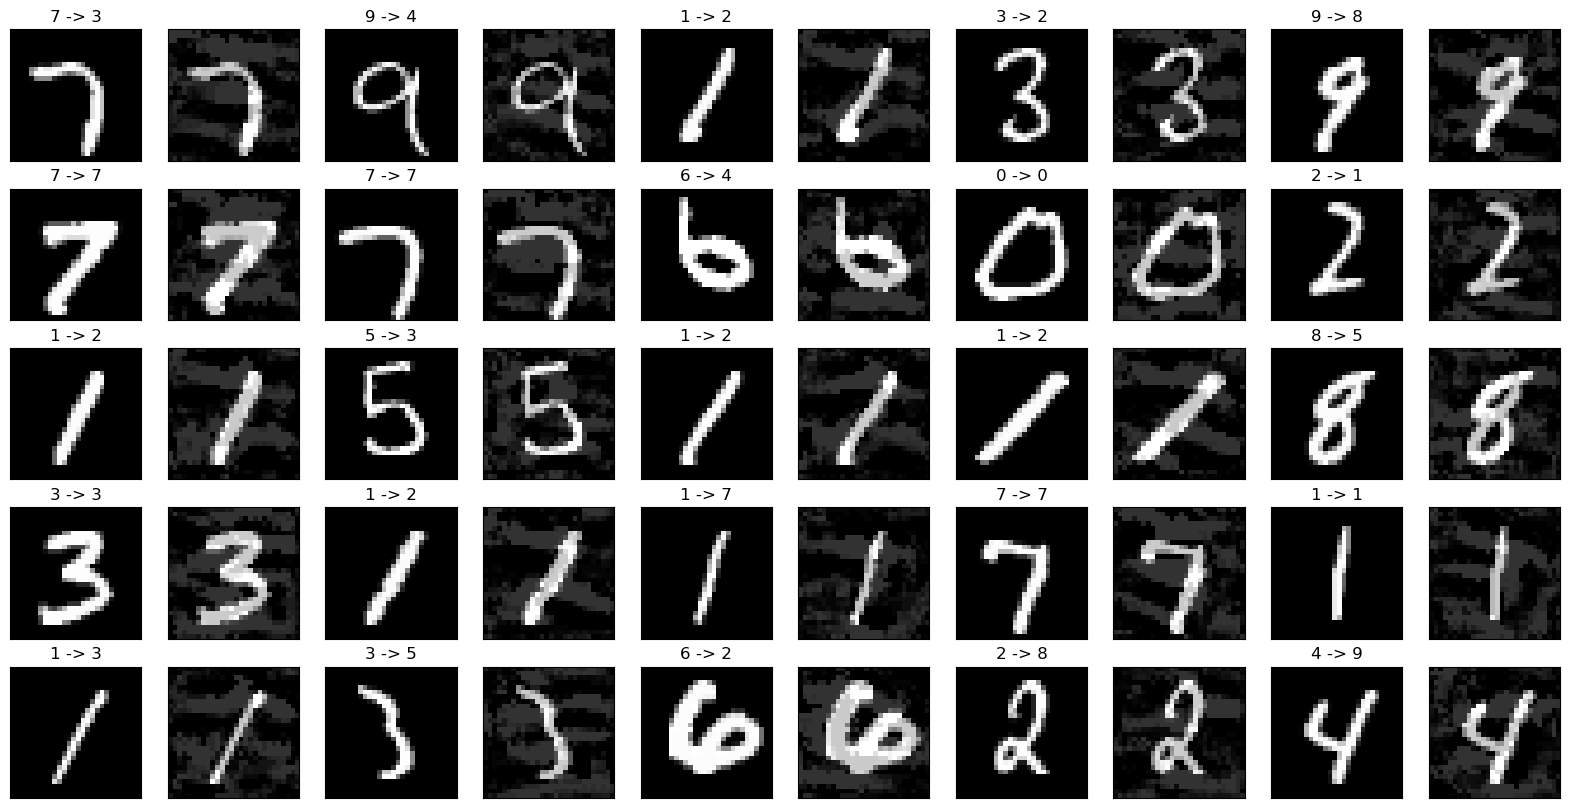

In [4]:
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target):
  n_cols = 5
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(n_cols*4,n_rows*2))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(clean_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()

plot_clean_and_adver(adver_example_by_IFGSM,adver_target,clean_example,clean_target)